In [2]:
import pandas as pd
import numpy as np
from time_series_transform.tensorflow_adopter import *
import time_series_transform.base as base
from time_series_transform.time_series_transformer import *
from sklearn.preprocessing import StandardScaler
from time_series_transform.tensorflow_adopter import *
from time_series_transform.stock_transform.base import *
from time_series_transform.stock_transform.stock_extractor import Portfolio_Extractor,Stock_Extractor
from time_series_transform.util import *
from matplotlib import pyplot as plt

In [9]:
tickList = [
#     '^GSPC',
#     "CL=F",
#     'CNY=X',
#     'JPY=X',
#     'GBPUSD=X',
#     'EURUSD=X'
    '2610.TW',
    '2618.TW',
    '2636.TW',
    '5607.TW',
]
pe = Portfolio_Extractor(tickList,'yahoo')
port = pe.get_portfolio_date('2000-06-24','2020-06-24')
port.remove_different_date()

In [12]:
labels = []
colList = ['Open', 'High', 'Low', 'Close']
for c in colList:
    port.make_technical_indicator(c,f'{c}_ma5',moving_average,windowSize = 5)
    port.make_technical_indicator(c,f'{c}_ma10',moving_average,windowSize = 10)
    port.make_technical_indicator(c,f'{c}_ema10',ema,span = 10)
#     port.make_technical_indicator(c,'wavelet_1',wavelet_denoising,wavelet='haar')
#     port.make_technical_indicator(f"{c}_ma5",'wavelet_1',wavelet_denoising,wavelet='haar')
#     port.make_technical_indicator(f"{c}_ma10",'wavelet_1',wavelet_denoising,wavelet='haar')
#     port.make_technical_indicator(f"{c}_wavelet_1",'wavelet_1',wavelet_denoising,wavelet='haar')
#     port.make_technical_indicator(f"{c}_ma5_wavelet_1",'1',wavelet_denoising,wavelet='haar')
#     port.make_technical_indicator(f"{c}_ma10_wavelet_1",'1',wavelet_denoising,wavelet='haar')
#     port.make_technical_indicator(f"{c}_wavelet_1",'1',wavelet_denoising,wavelet='haar')
    
    for t in tickList:
        labels.extend([f'{t}_{c}',f'{t}_{c}_ma5',f'{t}_{c}_ma10',f'{t}_{c}_ema10'])

In [13]:
df = port.get_portfolio_dataFrame()

In [17]:
trainDate = list(range(500,2500))
valDate = list(range(2500,2600))
testDate = list(range(2700,2710))
WINDOW_SIZE = 30
resDf = port.get_portfolio_dataFrame()
psd = Pandas_Time_Series_Tensor_Dataset(resDf)
timeSeriesDic = psd.expand_dataFrame_by_date('symbol','Date',True,False,True)

In [18]:
for i,v in enumerate(labels):
    if i == 0:
        psd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',trainDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',trainDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )

for step in range(1):
    if step == 0:
        psd.set_config(
            name = 'label',
            colNames = list(map(lambda x: f'2710.TW_Close_{str(x)}',trainDate)),
            tensorType = 'label',
            sequence_stack = None,
            isResponseVar = True,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'label_{step}',
            colNames = list(map(lambda x: f'2710.TW_Close_{str(x)}',map(lambda x: x+step ,trainDate))),
            tensorType = 'label',
            sequence_stack = 'label',
            isResponseVar = True,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )        

In [22]:
gen = psd.make_data_generator()
next(gen)

KeyError: '2710.TW_Close_500'

In [19]:
gen = psd.make_data_generator()
tfg = TFRecord_Writer('abc.tfRecord')
tfg.write_tfRecord(gen)
dtypeRecord_train = tfg.get_tfRecord_dtype()

KeyError: '2710.TW_Close_500'

In [12]:
psd = Pandas_Time_Series_Tensor_Dataset(resDf)
timeSeriesDic = psd.expand_dataFrame_by_date('symbol','Date',True,False,True)
for i,v in enumerate(labels):
    if i == 0:
        psd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',valDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',valDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )

for step in range(1):
    if step == 0:
        psd.set_config(
            name = 'label',
            colNames = list(map(lambda x: f'^GSPC_Close_{str(x)}',valDate)),
            tensorType = 'label',
            sequence_stack = None,
            isResponseVar = True,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        psd.set_config(
            name = f'label_{step}',
            colNames = list(map(lambda x: f'^GSPC_Close_{str(x)}',map(lambda x: x+step ,valDate))),
            tensorType = 'label',
            sequence_stack = 'label',
            isResponseVar = True,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )     

In [13]:
gen = psd.make_data_generator()
tfg = TFRecord_Writer('abc_val.tfRecord')
tfg.write_tfRecord(gen)
dtypeRecord_val = tfg.get_tfRecord_dtype()

In [14]:
tfr_train = TFRecord_Reader('abc.tfRecord',dtypeRecord_train)
tfr_val = TFRecord_Reader('abc_val.tfRecord',dtypeRecord_val)

In [15]:
def data_transform(X):
    # we only use the current week day and current price as feature
    # ignore the rest of data within the window since the change is very limited.
    X['current'] = X['sequence'][:,:-28,:]
    X['past'] = X['sequence'][:,-28:,:]
    Y = X['label']
    return (X,Y)

In [16]:
EVALUATION_INTERVAL = 250
Validation_STEP =  250
EPOCHS = 100


train_dataset = tfr_train.make_tfDataset()
val_dataset = tfr_val.make_tfDataset()
batchsize = 1000

train_dataset = train_dataset.unbatch().batch(3000).map(data_transform).\
prefetch(tf.data.experimental.AUTOTUNE).repeat()
val_dataset = val_dataset.unbatch().batch(3000).map(data_transform).\
prefetch(tf.data.experimental.AUTOTUNE).repeat()

In [35]:
def create_attention_model():
    seq_input = tf.keras.layers.Input(shape=(WINDOW_SIZE,len(labels)),name = 'sequence')
    
    #1d cnn
    seq = tf.keras.layers.BatchNormalization()(seq_input)
    seq = tf.keras.layers.Conv1D(30,11,activation = 'elu')(seq)
    seq = tf.keras.layers.MaxPooling1D(2)(seq)
    seq = tf.keras.layers.GRU(10)(seq)
    seq = tf.keras.layers.Flatten()(seq)  
    seq = tf.keras.layers.Dropout(0.2)(seq)
    seq = tf.keras.layers.Dense(30,'relu')(seq)
    seq = tf.keras.layers.Dropout(0.3)(seq)
    seq = tf.keras.layers.Dense(5,'relu')(seq)
    seq = tf.keras.layers.Dense(1)(seq)
    

    
    lstm_embed = tf.keras.models.Model({
        "sequence":seq_input
                                       },
                                       seq)

    rmse = tf.keras.metrics.RootMeanSquaredError()
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    huber = tf.keras.losses.Huber()
    adam = tf.keras.optimizers.Adam(lr = 0.02,
                                    decay = 0.0001,
                                    amsgrad = True
                                   )
    rmsp = tf.keras.optimizers.RMSprop(learning_rate=0.01, 
                                       rho=0.9)


    lstm_embed.compile(optimizer=adam, 
                       loss='mse',
                       metrics = ['mae','mse',rmse
                                 ]
                      )
    return lstm_embed

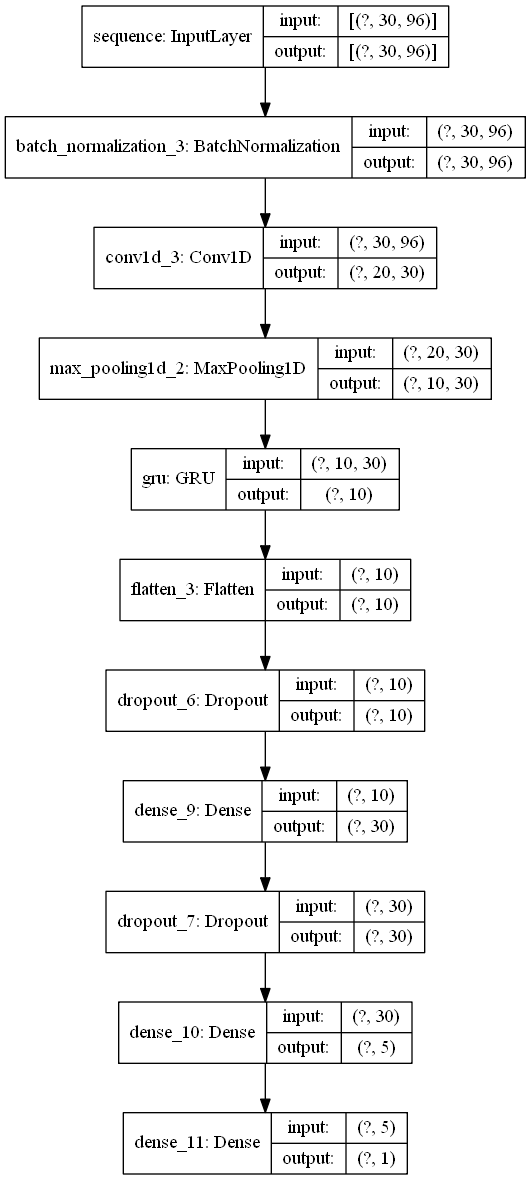

In [36]:
model = create_attention_model()
tf.keras.utils.plot_model(
    model, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)
model.fit(train_dataset,
          epochs=500,
          verbose = 2,
          validation_data = val_dataset,
          validation_steps=1,
          steps_per_epoch=1,
          callbacks= [early_stopping]
     )

Train for 1 steps, validate for 1 steps
Epoch 1/500
1/1 - 5s - loss: 3219269.5000 - mae: 1774.7644 - mse: 3219269.5000 - root_mean_squared_error: 1794.2323 - val_loss: 4651395.5000 - val_mae: 2156.5713 - val_mse: 4651395.5000 - val_root_mean_squared_error: 2156.7095
Epoch 2/500
1/1 - 0s - loss: 3217748.5000 - mae: 1774.3525 - mse: 3217748.5000 - root_mean_squared_error: 1793.8083 - val_loss: 4649984.0000 - val_mae: 2156.2439 - val_mse: 4649984.0000 - val_root_mean_squared_error: 2156.3821
Epoch 3/500
1/1 - 0s - loss: 3215449.7500 - mae: 1773.6868 - mse: 3215449.7500 - root_mean_squared_error: 1793.1675 - val_loss: 4647632.0000 - val_mae: 2155.6987 - val_mse: 4647632.0000 - val_root_mean_squared_error: 2155.8367
Epoch 4/500
1/1 - 0s - loss: 3213474.2500 - mae: 1773.1449 - mse: 3213474.2500 - root_mean_squared_error: 1792.6166 - val_loss: 4643543.5000 - val_mae: 2154.7498 - val_mse: 4643543.5000 - val_root_mean_squared_error: 2154.8882
Epoch 5/500
1/1 - 0s - loss: 3211433.0000 - mae: 177

Epoch 37/500
1/1 - 0s - loss: 2029383.0000 - mae: 1396.2019 - mse: 2029383.0000 - root_mean_squared_error: 1424.5641 - val_loss: 3126368.2500 - val_mae: 1767.9855 - val_mse: 3126368.2500 - val_root_mean_squared_error: 1768.1539
Epoch 38/500
1/1 - 0s - loss: 1921043.2500 - mae: 1355.2711 - mse: 1921043.2500 - root_mean_squared_error: 1386.0171 - val_loss: 3003911.0000 - val_mae: 1733.0077 - val_mse: 3003911.0000 - val_root_mean_squared_error: 1733.1794
Epoch 39/500
1/1 - 0s - loss: 1810788.1250 - mae: 1313.2855 - mse: 1810788.1250 - root_mean_squared_error: 1345.6553 - val_loss: 2876159.0000 - val_mae: 1695.7487 - val_mse: 2876159.0000 - val_root_mean_squared_error: 1695.9242
Epoch 40/500
1/1 - 0s - loss: 1709130.5000 - mae: 1273.8634 - mse: 1709130.5000 - root_mean_squared_error: 1307.3372 - val_loss: 2743406.7500 - val_mae: 1656.1434 - val_mse: 2743406.7500 - val_root_mean_squared_error: 1656.3232
Epoch 41/500
1/1 - 0s - loss: 1609567.1250 - mae: 1231.5726 - mse: 1609567.1250 - root_m

Epoch 74/500
1/1 - 0s - loss: 213487.9375 - mae: 372.8830 - mse: 213487.9375 - root_mean_squared_error: 462.0475 - val_loss: 119608.2266 - val_mae: 344.9819 - val_mse: 119608.2266 - val_root_mean_squared_error: 345.8442
Epoch 75/500
1/1 - 0s - loss: 224188.8281 - mae: 378.8315 - mse: 224188.8281 - root_mean_squared_error: 473.4858 - val_loss: 141169.7969 - val_mae: 374.9321 - val_mse: 141169.7969 - val_root_mean_squared_error: 375.7257
Epoch 76/500
1/1 - 0s - loss: 206850.8281 - mae: 369.1823 - mse: 206850.8281 - root_mean_squared_error: 454.8086 - val_loss: 163522.4219 - val_mae: 403.6418 - val_mse: 163522.4219 - val_root_mean_squared_error: 404.3791
Epoch 77/500
1/1 - 0s - loss: 202494.2188 - mae: 356.5979 - mse: 202494.2188 - root_mean_squared_error: 449.9936 - val_loss: 185516.1562 - val_mae: 430.0237 - val_mse: 185516.1562 - val_root_mean_squared_error: 430.7159
Epoch 78/500
1/1 - 0s - loss: 185865.4219 - mae: 351.5231 - mse: 185865.4219 - root_mean_squared_error: 431.1211 - val_l

Epoch 112/500
1/1 - 0s - loss: 188677.7500 - mae: 352.6904 - mse: 188677.7500 - root_mean_squared_error: 434.3705 - val_loss: 177704.7500 - val_mae: 420.8432 - val_mse: 177704.7500 - val_root_mean_squared_error: 421.5504
Epoch 113/500
1/1 - 0s - loss: 193052.4375 - mae: 349.1149 - mse: 193052.4375 - root_mean_squared_error: 439.3773 - val_loss: 182326.3750 - val_mae: 426.2987 - val_mse: 182326.3750 - val_root_mean_squared_error: 426.9969
Epoch 114/500
1/1 - 0s - loss: 183640.4844 - mae: 350.4381 - mse: 183640.4844 - root_mean_squared_error: 428.5330 - val_loss: 186515.4062 - val_mae: 431.1840 - val_mse: 186515.4062 - val_root_mean_squared_error: 431.8743
Epoch 115/500
1/1 - 0s - loss: 204454.5312 - mae: 363.8333 - mse: 204454.5312 - root_mean_squared_error: 452.1665 - val_loss: 190511.7344 - val_mae: 435.7935 - val_mse: 190511.7344 - val_root_mean_squared_error: 436.4765
Epoch 116/500
Restoring model weights from the end of the best epoch.
1/1 - 0s - loss: 185124.8594 - mae: 351.7031 -

In [38]:
prd = model.predict(train_dataset,steps = 1)
val_prd = model.predict(val_dataset, steps=1)

In [39]:
def plot_diff(prcd,resDf,label,step):
    real = resDf[list(map(lambda x: f'^GSPC_Close_{x}',label))].transpose().values
    plotDf = pd.DataFrame(real[step:]).tail(len(prcd[step]))
    plotDf['prd_Close'] = prcd[step]
    return plotDf
def plot_diff(prcd,resDf,label,step):
    real = resDf[list(map(lambda x: f'^GSPC_Close_{x}',label))].transpose().values
    plotDf = pd.DataFrame(real).tail(len(prcd))
    plotDf['prd_Close'] = prcd
    return plotDf

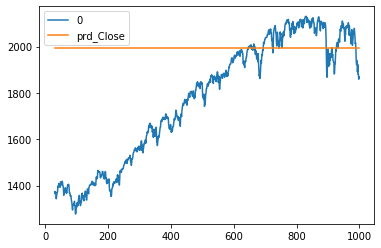

In [40]:

plotDf = plot_diff(prd,psd.df,trainDate,0)
plotDf.plot()

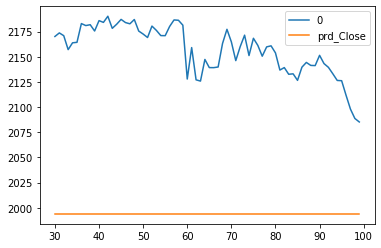

In [41]:
plotDf = plot_diff(val_prd,psd.df,valDate,20)
plotDf.plot()

In [21]:
tpsd = Pandas_Time_Series_Tensor_Dataset(df)
timeSeriesDic = tpsd.expand_dataFrame_by_date('symbol','Date')
for i,v in enumerate(labels):
    if i == 0:
        tpsd.set_config(
            name = f'sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',testDate)),
            tensorType = 'sequence',
            sequence_stack = None,
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
    else:
        tpsd.set_config(
            name = f'{v}_sequence',
            colNames = list(map(lambda x: f'{v}_{str(x)}',testDate)),
            tensorType = 'sequence',
            sequence_stack = "sequence",
            isResponseVar = False,
            windowSize = WINDOW_SIZE,
            seqSize = 1837,
            outType = np.float32
        )
        
tpsd.set_config(
    name = 'label',
    colNames = list(map(lambda x: f'sp500_Close_{str(x)}',testDate)),
    tensorType = 'label',
    sequence_stack = None,
    isResponseVar = True,
    windowSize = WINDOW_SIZE,
    seqSize = 1837,
    outType = np.float32
)

In [22]:
tgen = psd.make_data_generator()
test_prediction = model.predict(tgen)

In [23]:
plotDf = plot_diff(test_prediction,tpsd.df,testDate)
plotDf.plot()

KeyError: "None of [Index(['sp500_Close_4900', 'sp500_Close_4901', 'sp500_Close_4902',\n       'sp500_Close_4903', 'sp500_Close_4904', 'sp500_Close_4905',\n       'sp500_Close_4906', 'sp500_Close_4907', 'sp500_Close_4908',\n       'sp500_Close_4909', 'sp500_Close_4910', 'sp500_Close_4911',\n       'sp500_Close_4912', 'sp500_Close_4913', 'sp500_Close_4914',\n       'sp500_Close_4915', 'sp500_Close_4916', 'sp500_Close_4917',\n       'sp500_Close_4918', 'sp500_Close_4919', 'sp500_Close_4920',\n       'sp500_Close_4921', 'sp500_Close_4922', 'sp500_Close_4923',\n       'sp500_Close_4924', 'sp500_Close_4925', 'sp500_Close_4926',\n       'sp500_Close_4927', 'sp500_Close_4928', 'sp500_Close_4929',\n       'sp500_Close_4930', 'sp500_Close_4931', 'sp500_Close_4932',\n       'sp500_Close_4933', 'sp500_Close_4934', 'sp500_Close_4935',\n       'sp500_Close_4936', 'sp500_Close_4937', 'sp500_Close_4938',\n       'sp500_Close_4939', 'sp500_Close_4940', 'sp500_Close_4941',\n       'sp500_Close_4942', 'sp500_Close_4943', 'sp500_Close_4944',\n       'sp500_Close_4945', 'sp500_Close_4946', 'sp500_Close_4947',\n       'sp500_Close_4948', 'sp500_Close_4949', 'sp500_Close_4950',\n       'sp500_Close_4951', 'sp500_Close_4952', 'sp500_Close_4953',\n       'sp500_Close_4954', 'sp500_Close_4955', 'sp500_Close_4956',\n       'sp500_Close_4957', 'sp500_Close_4958', 'sp500_Close_4959',\n       'sp500_Close_4960', 'sp500_Close_4961', 'sp500_Close_4962',\n       'sp500_Close_4963', 'sp500_Close_4964', 'sp500_Close_4965',\n       'sp500_Close_4966', 'sp500_Close_4967', 'sp500_Close_4968',\n       'sp500_Close_4969', 'sp500_Close_4970', 'sp500_Close_4971',\n       'sp500_Close_4972', 'sp500_Close_4973', 'sp500_Close_4974',\n       'sp500_Close_4975', 'sp500_Close_4976', 'sp500_Close_4977',\n       'sp500_Close_4978', 'sp500_Close_4979', 'sp500_Close_4980',\n       'sp500_Close_4981', 'sp500_Close_4982', 'sp500_Close_4983',\n       'sp500_Close_4984', 'sp500_Close_4985', 'sp500_Close_4986',\n       'sp500_Close_4987', 'sp500_Close_4988', 'sp500_Close_4989',\n       'sp500_Close_4990', 'sp500_Close_4991', 'sp500_Close_4992',\n       'sp500_Close_4993', 'sp500_Close_4994', 'sp500_Close_4995',\n       'sp500_Close_4996', 'sp500_Close_4997', 'sp500_Close_4998',\n       'sp500_Close_4999'],\n      dtype='object')] are in the [columns]"

In [24]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(plotDf[0],plotDf.prd_High))

AttributeError: 'DataFrame' object has no attribute 'prd_High'